In [4]:
import numpy as np

import os
import os.path as op

import matplotlib.pyplot as plt

import h5py

import nibabel as nib
from nilearn.datasets import load_mni152_template
from nilearn import plotting

import importlib

import interpolation as interp

In [5]:
# load template
path_to_dir = "/home/acionca/Documents/data/hcph-template/multivar-v00/derivatives/ants-t1N4bfcorr-b80-norm_run-1/"
template_files = ["A_tpl_template0.nii.gz", "A_tpl_template1.nii.gz"]
path_to_templates = [op.join(path_to_dir, file) for file in template_files]

t1w_template = nib.load(path_to_templates[0])

print(f"Template image has shape: {t1w_template.shape} and affine\n{t1w_template.affine}")

resolution = 0.4
mni_template = load_mni152_template(resolution)
print(f"MNI image has shape: {mni_template.shape} and affine\n{mni_template.affine}")

mni_saveloc = "/home/acionca/Documents/data/hcph-template/mni_template"
mni_filename = f"mni_template-res{resolution}mm.nii.gz"
os.makedirs(mni_saveloc, exist_ok=True)

if not op.isfile(op.join(mni_saveloc, mni_filename)):
    print("Saving MNI Template")
    mni_template.to_filename(op.join(mni_saveloc, mni_filename))

Template image has shape: (252, 288, 192) and affine
[[ 7.98610985e-01 -3.91079826e-12  3.20000004e-06 -1.00127357e+02]
 [-8.86697744e-12  7.98610985e-01  3.20000004e-06 -8.80923615e+01]
 [-3.19444393e-06 -3.19444393e-06  8.00000012e-01 -6.56193848e+01]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
MNI image has shape: (491, 581, 471) and affine
[[   0.4    0.     0.   -98. ]
 [   0.     0.4    0.  -134. ]
 [   0.     0.     0.4  -72. ]
 [   0.     0.     0.     1. ]]


In [6]:
coords_in = [[i, i, i] for i in np.arange(10)]

print(interp.map_coordinates(coords_in, t1w_template, mni_template))

[[  2.66385392 -57.4843245   -7.97598783]
 [  3.16472156 -56.98345686  -7.47598383]
 [  3.6655892  -56.48258922  -6.97597984]
 [  4.16645684 -55.98172158  -6.47597585]
 [  4.66732449 -55.48085394  -5.97597186]
 [  5.16819213 -54.9799863   -5.47596786]
 [  5.66905977 -54.47911866  -4.97596387]
 [  6.16992741 -53.97825102  -4.47595988]
 [  6.67079505 -53.47738337  -3.97595589]
 [  7.17166269 -52.97651573  -3.47595189]]


In [7]:
mni_empty = nib.Nifti1Image(np.zeros(mni_template.shape), affine=mni_template.affine)
mni_empty_array = mni_empty.get_fdata()

grid_shape = mni_empty.shape
grid_affine = mni_empty.affine
print(f"Grid has shape {grid_shape} with voxel size {grid_affine[0, 0]}")

Grid has shape (491, 581, 471) with voxel size 0.4


In [8]:
importlib.reload(interp)

from itertools import product

t1w_files = interp.get_anat_filenames(path_to_dir, pattern="desc-N4corrdennorm")
t1w_files_wDir = [op.join(path_to_dir, file) for file in t1w_files]

boundary = interp.consensus_boundary(t1w_files_wDir, mni_empty)

Consensus boundary is: 
 [[  1 112   2]
 [491 581 426]]


In [10]:
importlib.reload(interp)
from tqdm.notebook import tqdm

weight = 0.3

x_dim = np.arange(boundary[0, 0], boundary[1, 0]).astype(int)
y_dim = np.arange(boundary[0, 1], boundary[1, 1]).astype(int)
z_dim = np.arange(boundary[0, 2], boundary[1, 2]).astype(int)

print(f"Boundary has size {len(x_dim)}x{len(y_dim)}x{len(z_dim)} "
      f"which is equal to {len(x_dim)*len(y_dim)*len(z_dim)} voxels.")

grid_array = np.zeros_like(mni_empty_array)
grid_array_w = grid_array.copy()

for slice_id in tqdm(np.arange(len(z_dim))[300:310]):
      # Iterate over slices
      #slice_id = 200
      z_dim_sliced = z_dim[slice_id]
      one_slice_midCoords = [(prod[0], prod[1], prod[2]) for prod in product(x_dim, y_dim, [z_dim_sliced])]
      one_slice_Coords = np.array(one_slice_midCoords).astype(int)
      one_slice_midCoords = np.array(one_slice_midCoords) + 0.5

      print(f"Slice has {len(one_slice_midCoords)} voxels.")

      files_to_loop = t1w_files.copy()

      slice_array = np.zeros((len(files_to_loop), grid_array.shape[0], grid_array.shape[1]))
      slice_array_w = np.zeros((len(files_to_loop), grid_array.shape[0], grid_array.shape[1]))

      for file_id, file in enumerate(files_to_loop):
            img = nib.load(op.join(path_to_dir, file))

            array_values_weighted, array_values = interp.dist_weighted_sampling(
                  img, mni_empty, one_slice_midCoords, return_unweighted=True
                  )

            one_slice_ids = (one_slice_Coords.T[0], one_slice_Coords.T[1])

            slice_array[file_id][one_slice_ids] = array_values
            slice_array_w[file_id][one_slice_ids] = array_values_weighted

      grid_array[..., slice_id] = slice_array.mean(axis=0)
      grid_array_w[..., slice_id] = slice_array_w.mean(axis=0)

#inter_img = nib.Nifti1Image(grid_array, affine=mni_empty.affine)
#inter_img_w = nib.Nifti1Image(grid_array_w, affine=mni_empty.affine)
#
#inter_img.to_filename("/home/acionca/Documents/data/hcph-template/interpolated_template.nii.gz")
#inter_img_w.to_filename("/home/acionca/Documents/data/hcph-template/interpolated_template_weighted.nii.gz")

Boundary has size 490x469x424 which is equal to 97439440 voxels.


  0%|          | 0/10 [00:00<?, ?it/s]

Slice has 229810 voxels.
Slice has 229810 voxels.
Slice has 229810 voxels.
Slice has 229810 voxels.
Slice has 229810 voxels.
Slice has 229810 voxels.
Slice has 229810 voxels.
Slice has 229810 voxels.
Slice has 229810 voxels.
Slice has 229810 voxels.


In [17]:
importlib.reload(interp)
from tqdm.notebook import tqdm

midVox = 0.5
weight = 0.3

x_dim = np.arange(boundary[0, 0], boundary[1, 0]).astype(int)
y_dim = np.arange(boundary[0, 1], boundary[1, 1]).astype(int)
z_dim = np.arange(boundary[0, 2], boundary[1, 2]).astype(int)

print(f"Boundary has size {len(x_dim)}x{len(y_dim)}x{len(z_dim)} "
      f"which is equal to {len(x_dim)*len(y_dim)*len(z_dim)} voxels.")

grid_array = np.zeros_like(mni_empty_array)
grid_array_w = grid_array.copy()

slab_size = 2

for slab_id in [0, 1]:
      z_dim_sliced = z_dim[300+slab_size*slab_id:300+(1+slab_id)*slab_size]

      print("ZCOORDS", z_dim_sliced)
      
      one_slice_midCoords = [(prod[0], prod[1], prod[2]) for prod in product(x_dim, y_dim, z_dim_sliced)]
      one_slice_Coords = np.array(one_slice_midCoords).astype(int)
      one_slice_midCoords = np.array(one_slice_midCoords) + 0.5

      print(f"Slice has {len(one_slice_midCoords)} voxels.")

      files_to_loop = t1w_files.copy()
      slice_array = np.zeros((len(files_to_loop), grid_array.shape[0], grid_array.shape[1]))
      slice_array_w = np.zeros((len(files_to_loop), grid_array.shape[0], grid_array.shape[1]))

      for file_id, file in enumerate(files_to_loop):
            img = nib.load(op.join(path_to_dir, file))
            array_values_weighted, array_values = interp.dist_weighted_sampling(
                  img, mni_empty, one_slice_midCoords, return_unweighted=True
                  )
            one_slice_ids = (one_slice_Coords.T[0], one_slice_Coords.T[1])
            slice_array[file_id][one_slice_ids] = array_values
            slice_array_w[file_id][one_slice_ids] = array_values_weighted

      grid_array[..., slice_id] = slice_array.mean(axis=0)
      grid_array_w[..., slice_id] = slice_array_w.mean(axis=0)

del grid_array, grid_array_w, one_slice_Coords, one_slice_midCoords, slice_array, slice_array_w

#inter_img = nib.Nifti1Image(grid_array, affine=mni_empty.affine)
#inter_img_w = nib.Nifti1Image(grid_array_w, affine=mni_empty.affine)
#
#inter_img.to_filename("/home/acionca/Documents/data/hcph-template/interpolated_template.nii.gz")
#inter_img_w.to_filename("/home/acionca/Documents/data/hcph-template/interpolated_template_weighted.nii.gz")

Boundary has size 490x469x424 which is equal to 97439440 voxels.
ZCOORDS [302 303]
Slice has 459620 voxels.
ZCOORDS [304 305]
Slice has 459620 voxels.


In [26]:
from nitransforms.base import ImageGrid

mni_grid = ImageGrid(mni_empty)
one_img_grid = ImageGrid(t1w_files_wDir[0])

print("index")
for some_coords in mni_grid.ndindex:
    #print(some_coords.shape)
    print(some_coords[0], some_coords[-1])

coords
(13934592,)
-100.12735748291016 100.32461102102448
(13934592,)
-88.09236145019531 141.1096025226831
(13934592,)
-65.619384765625 87.1788989004358
index
0 490
0 580
0 470


In [33]:
importlib.reload(interp)

interp.dist_weighted_interpolation(t1w_files_wDir, mni_empty, slab_size=10, v=True)

Consensus boundary is: 
 [[  1 112   2]
 [491 581 426]]
Boundary has size 490x469x424 which is equal to 97439440 voxels.
Data has been split in:
37 slabs of size 10, 6 slabs of size 9
Slice has 2298100 voxels.
(35, 490, 469, 10)
[  1   1   1 ... 490 490 490]
Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/acionca/miniconda3/envs/hcph-template/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_380540/947308466.py", line 3, in <module>
    interp.dist_weighted_interpolation(t1w_files_wDir, mni_empty, slab_size=10, v=True)
  File "/home/acionca/Documents/code/hcph-template/interpolation.py", line 261, in dist_weighted_interpolation
    slab_values[file_id][slab_coords_ids],
IndexError: index 490 is out of bounds for axis 0 with size 490

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/acionca/miniconda3/envs/hcph-template/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 2120, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
  File "/home/acionca/miniconda3/envs/hcph-template/lib/python3.9/site-packages/IPython/core/ultratb.py

NameError: name 'slice_array' is not defined

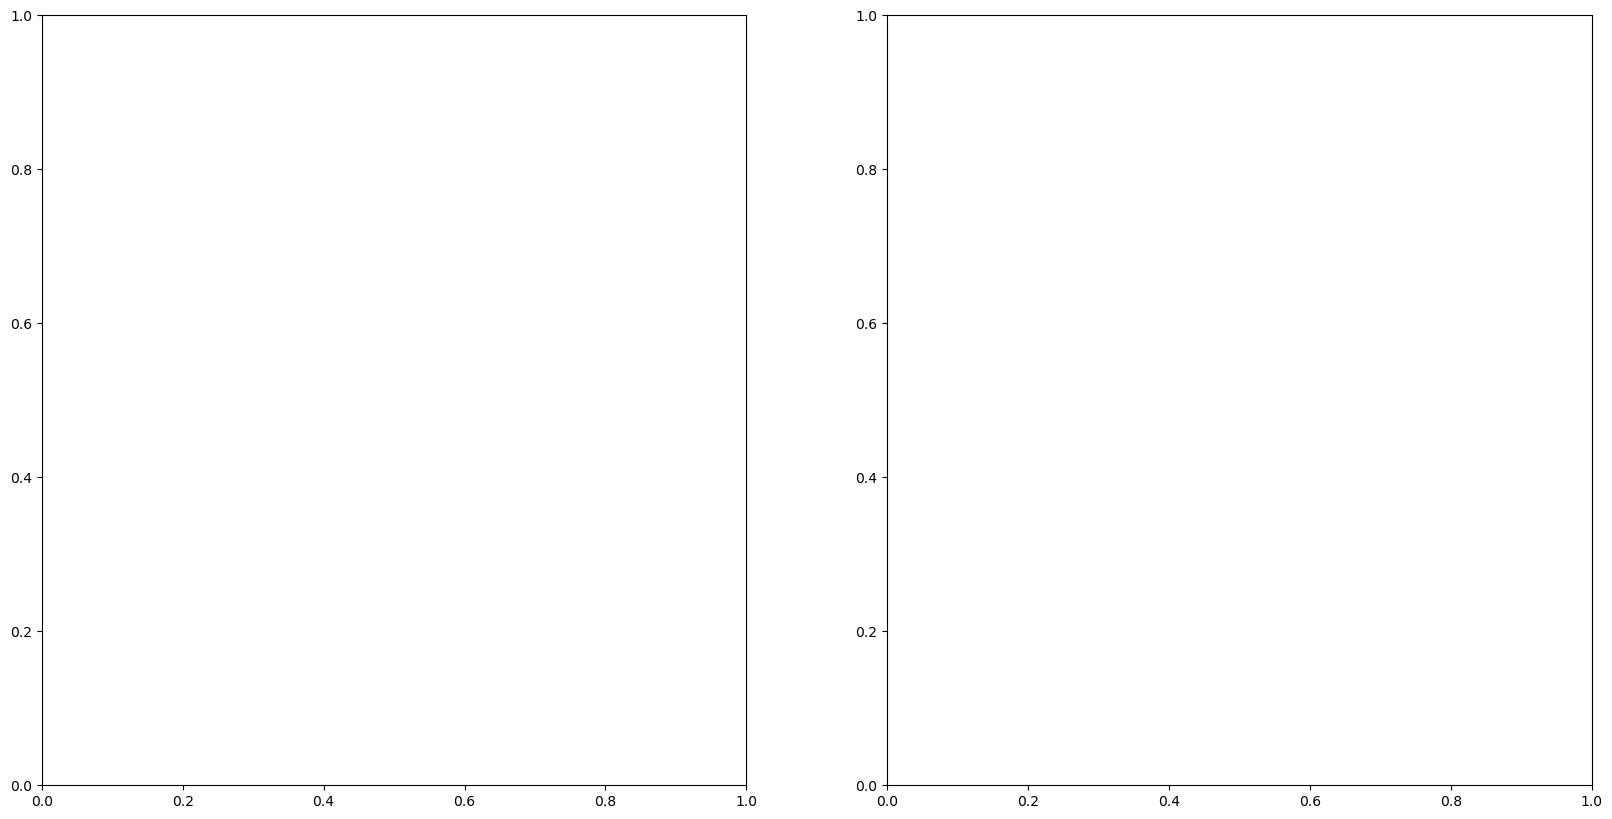

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ax[0].imshow(slice_array.mean(axis=0))
ax[1].imshow(slice_array_w.mean(axis=0))